In [1]:
import jax
import jax.numpy as jnp
print(jax.devices())
print(jnp.sin(jnp.pi/2))

[CudaDevice(id=0)]
1.0


In [2]:
import numpy as np
import os
import dill
script_dir = os.getcwd()


from sde.SDE_ARFF_lib import (
    SDEARFFTrain,
    NNHyperparameters
)


%load_ext autoreload
%autoreload 2



In [3]:
ex_name = "ex3-1D_cubic"

# load true functions
with open(f"true_functions/{ex_name}.pkl", "rb") as f:
    true_functions = dill.load(f)

true_drift = true_functions["drift"]
true_diffusion = true_functions["diffusion"]

# load data
data_name = f"{ex_name}_time0.1_SS0.01_ntraj1000"
training_data = np.load(f"training_data/{data_name}.npz")

n_dimensions = training_data["n_dimensions"]
trajectory_step_size = training_data["step_size"]
xlim = training_data["xlim"]
trajectories = training_data["trajectories"]

In [4]:
print(true_drift)
print(type(true_drift))


<function true_drift at 0x7f9f541f2d40>
<class 'function'>


In [5]:
# network parameters
validation_split = 0.1
ARFF_validation_split = 0.1

drift_param = NNHyperparameters(K=2**7, 
                                M_min=10,
                                M_max=100,
                                lambda_reg=2e-3,
                                gamma=1,
                                delta=0.1,
                                name='drift')
diffusion_param = NNHyperparameters(K=drift_param.K,
                               M_min=drift_param.M_min,
                               M_max=drift_param.M_max,
                               lambda_reg=drift_param.lambda_reg,
                               gamma=drift_param.gamma,
                               delta=drift_param.delta,
                               name='diffusion')


In [6]:
random_seed = 1
rng = np.random.default_rng(random_seed)

# subsample data
step_size = 0.01
sampled_trajectories = trajectories[:, :, ::int(step_size/trajectory_step_size)]
x_data = sampled_trajectories[:, :, :-1].reshape(-1, n_dimensions)
y_data = sampled_trajectories[:, :, 1:].reshape(-1, n_dimensions)

step_sizes = np.zeros((x_data.shape[0], 1)) + step_size


drift epoch: 43


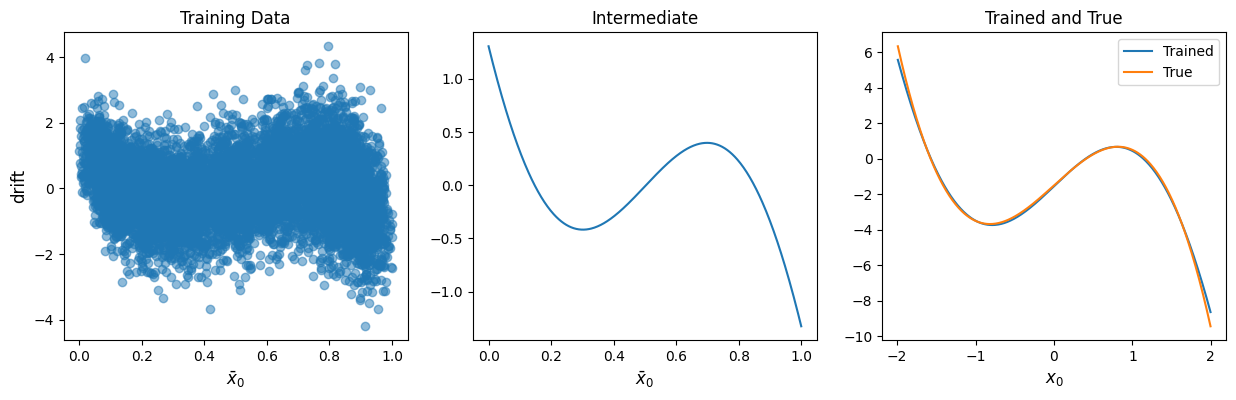

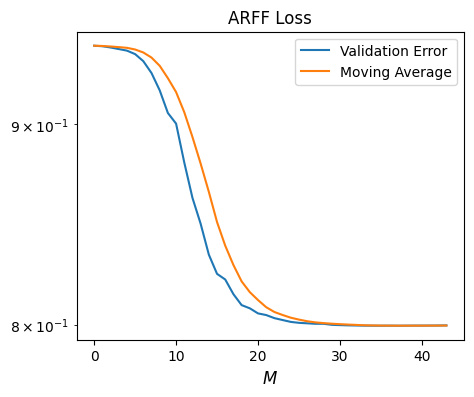

diffusion epoch: 10


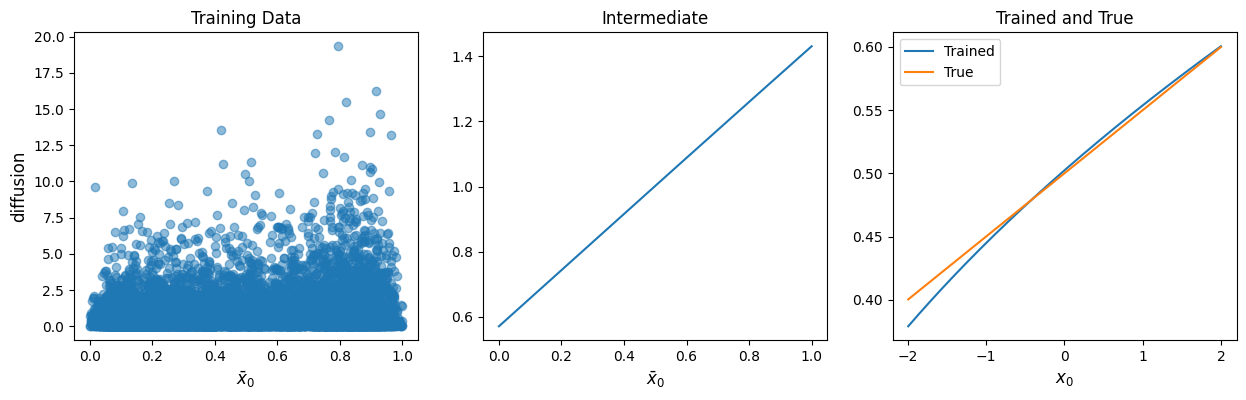

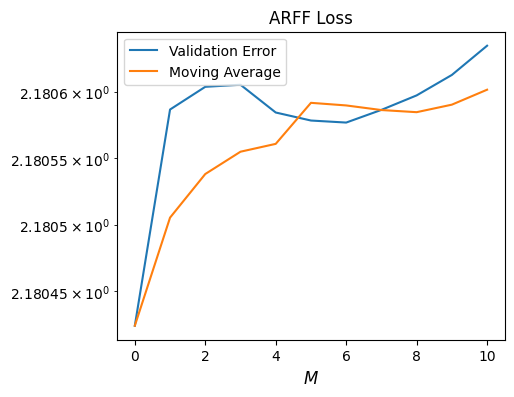

NameError: name 'tf' is not defined

In [52]:
from sde.SDE_ARFF_lib import (
    SDEARFFTrain,
    NNHyperparameters
)

# build network
SAT = SDEARFFTrain(n_dimensions=n_dimensions, random_seed=random_seed, resampling=True)

# train network
hist = SAT.train_model(drift_param, diffusion_param, true_drift, true_diffusion, x_data, y_data, step_sizes=step_sizes, validation_split=validation_split, ARFF_validation_split=ARFF_validation_split, plot=True)


amp = [[2.2931023e-05+0.j]
 [2.2932367e-05+0.j]
 [2.2932347e-05+0.j]
 [2.2931856e-05+0.j]
 [2.2931854e-05+0.j]
 [2.2931848e-05+0.j]
 [2.2931894e-05+0.j]
 [2.2931888e-05+0.j]
 [2.2931934e-05+0.j]
 [2.2931978e-05+0.j]
 [2.2931992e-05+0.j]
 [2.2931974e-05+0.j]
 [2.2932019e-05+0.j]
 [2.2932021e-05+0.j]
 [2.2932085e-05+0.j]
 [2.2932016e-05+0.j]
 [2.2932067e-05+0.j]
 [2.2932009e-05+0.j]
 [2.2932083e-05+0.j]
 [2.2932092e-05+0.j]
 [2.2932065e-05+0.j]
 [2.2932014e-05+0.j]
 [2.2932049e-05+0.j]
 [2.2932030e-05+0.j]
 [2.2932058e-05+0.j]
 [2.2932029e-05+0.j]
 [2.2932039e-05+0.j]
 [2.2932021e-05+0.j]
 [2.2932030e-05+0.j]
 [2.2932038e-05+0.j]
 [2.2932030e-05+0.j]
 [2.2932014e-05+0.j]
 [2.2931870e-05+0.j]
 [2.2931901e-05+0.j]
 [2.2931914e-05+0.j]
 [2.2931872e-05+0.j]
 [2.2931848e-05+0.j]
 [2.2931868e-05+0.j]
 [2.2931932e-05+0.j]
 [2.2931863e-05+0.j]
 [2.2931888e-05+0.j]
 [2.2931892e-05+0.j]
 [2.2931901e-05+0.j]
 [2.2931878e-05+0.j]
 [2.2931914e-05+0.j]
 [2.2931881e-05+0.j]
 [2.2931890e-05+0.j]
 [2.293

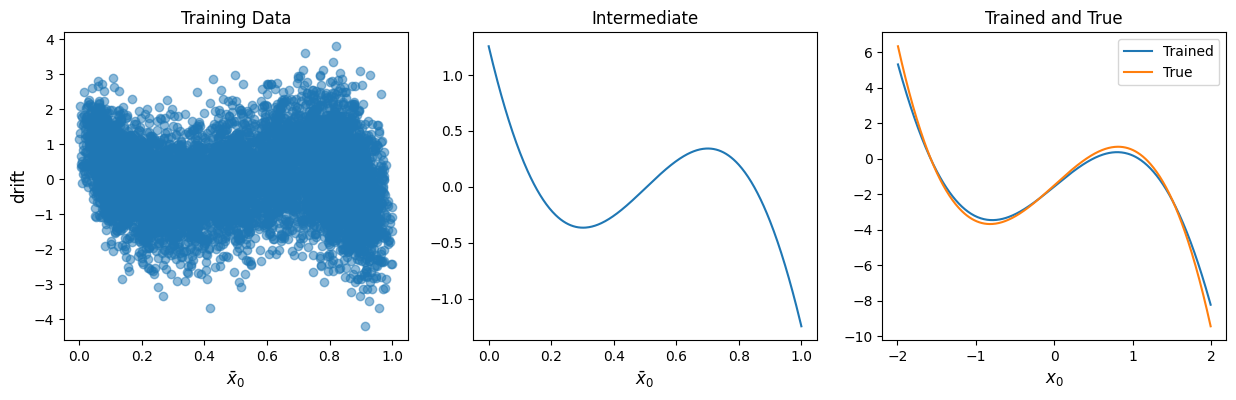

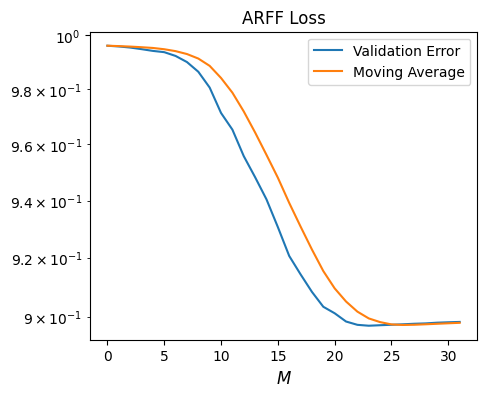

amp = [[0.00783303+0.j]
 [0.00783318+0.j]
 [0.00783305+0.j]
 [0.00783304+0.j]
 [0.00783309+0.j]
 [0.00783309+0.j]
 [0.0078331 +0.j]
 [0.00783306+0.j]
 [0.0078331 +0.j]
 [0.00783309+0.j]
 [0.00783308+0.j]
 [0.00783308+0.j]
 [0.00783308+0.j]
 [0.00783309+0.j]
 [0.0078331 +0.j]
 [0.0078331 +0.j]
 [0.00783308+0.j]
 [0.00783309+0.j]
 [0.00783309+0.j]
 [0.00783309+0.j]
 [0.00783308+0.j]
 [0.00783309+0.j]
 [0.00783308+0.j]
 [0.00783309+0.j]
 [0.0078331 +0.j]
 [0.00783309+0.j]
 [0.0078331 +0.j]
 [0.00783309+0.j]
 [0.00783309+0.j]
 [0.00783309+0.j]
 [0.00783308+0.j]
 [0.00783309+0.j]
 [0.00783289+0.j]
 [0.0078329 +0.j]
 [0.0078329 +0.j]
 [0.0078329 +0.j]
 [0.0078329 +0.j]
 [0.0078329 +0.j]
 [0.00783289+0.j]
 [0.00783289+0.j]
 [0.00783291+0.j]
 [0.00783289+0.j]
 [0.0078329 +0.j]
 [0.0078329 +0.j]
 [0.00783289+0.j]
 [0.0078329 +0.j]
 [0.00783289+0.j]
 [0.0078329 +0.j]
 [0.0078329 +0.j]
 [0.0078329 +0.j]
 [0.0078329 +0.j]
 [0.00783289+0.j]
 [0.0078329 +0.j]
 [0.00783289+0.j]
 [0.0078329 +0.j]
 [0.

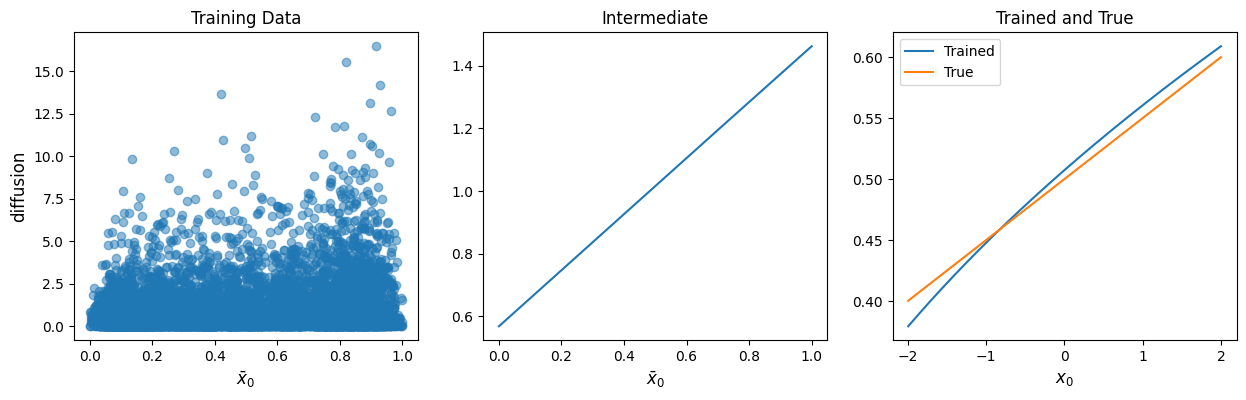

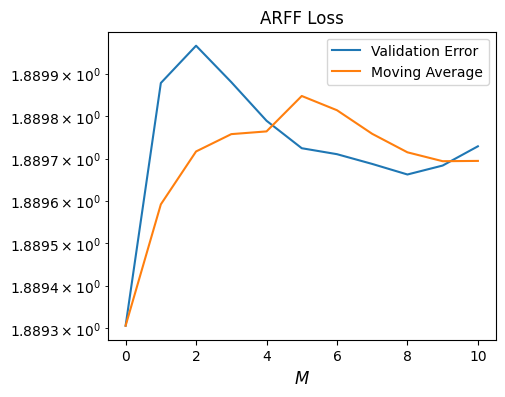

KeyError: 'drift_RMSE'

In [9]:
from sde.SDE_ARFF_JAX_lib import (
    SDEARFFTrain,
    NNHyperparameters
)

# build network
SAT = SDEARFFTrain(n_dimensions=n_dimensions, random_seed=random_seed, resampling=True)

# train network
hist = SAT.train_model(drift_param, diffusion_param, true_drift, true_diffusion, x_data, y_data, step_sizes=step_sizes, validation_split=validation_split, ARFF_validation_split=ARFF_validation_split, plot=True)
